In [1]:
import torch
import numpy as np
import time
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline

from Train import MultivariateSigmoidNormalDiag
from Model import Actor, Critic
from VecEnv import EIEnv


In [2]:
env=EIEnv(env_id=22,gamma=0.9)
[seed]=env.seed()

/home/zhaoming/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
actor_net = Actor(env.observation_space.shape[0]+1,env.action_space.shape[0])
critic_net = Critic(env.observation_space.shape[0]+1,env.action_space.shape[0])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_net = actor_net.to(device)
critic_net = critic_net.to(device)
checkpoint = torch.load('./models/now')
actor_net.load_state_dict(checkpoint['actor_model_state_dict'],strict=False)
critic_net.load_state_dict(checkpoint['critic_model_state_dict'],strict=False)
actor_net.eval()
critic_net.eval()

Critic(
  (v): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [4]:
gamma=0.9
env.seed()
steps=[]
values = np.zeros(1440)
with torch.no_grad():
    observation = env.preset()
    for step in range(int(1440)):
        observation_in=env.observation_scaler(observation)
        
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)
        # network forward pass
        policies_mu, policies_sigma = actor_net(observation_in)
        values[step] = critic_net(observation_in).detach().cpu().numpy()
        #policies_prob = MultivariateSigmoidNormalDiag(policies_mu,policies_sigma+1e-10)
        #action = policies_prob.sample()
        action=policies_mu
        # gather env data, reset done envs and update their obs
        observation, reward, done, info = env.step(action.detach().cpu().numpy()[0])
        steps.append((np.array([reward]), action.detach().cpu().numpy(), observation ))


n_step=len(steps)-1

Q_x_a=reward
out=[None] * n_step
for i in reversed(range(n_step)):
    reward, action, observation=steps[i]
    Q_x_a=reward+Q_x_a*gamma
    out[i]=observation, action, reward, Q_x_a

x,a,r,Q_x_a=map(lambda l:np.concatenate(l),zip(*out))
x=x.reshape((-1,env.observation_space.shape[0]+1))
a=a.reshape((-1,env.action_space.shape[0]))


In [5]:
policies_mu, policies_sigma 

(tensor([[1.0000, 1.0000, 1.0000]], device='cuda:0'),
 tensor([[0.2044, 0.1676, 0.0993]], device='cuda:0'))

In [6]:
x.shape

(1439, 8)

In [7]:
num=0
for i in range(1439):
    if (a[i,0]>0.1) & (a[i,0]<0.9):
        num+=1
print(num)

2


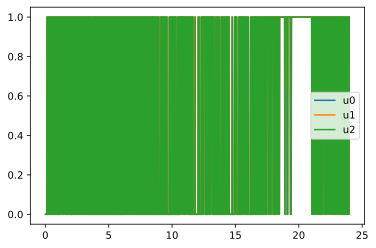

In [8]:
plt.plot(x[:,0], a[:,0], label='u0')
plt.plot(x[:,0], a[:,1], label='u1')
plt.plot(x[:,0], a[:,2], label='u2')
plt.legend()
plt.show()

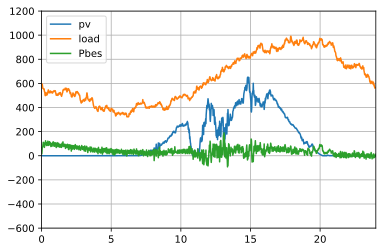

In [9]:
plt.plot(x[:,0], x[:,1], label='pv')
plt.plot(x[:,0], x[:,2], label='load')
plt.plot(x[:,0], x[:,2]-x[:,1]-x[:,3]-x[:,4]-x[:,5], label='Pbes')
plt.ylim(-600,1200)
plt.xlim(0,24)
plt.grid()
plt.legend()
plt.show()

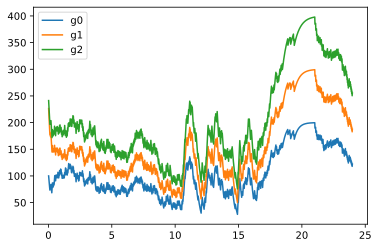

In [10]:
plt.plot(x[:,0], x[:,3], label='g0')
plt.plot(x[:,0], x[:,4], label='g1')
plt.plot(x[:,0], x[:,5], label='g2')
plt.legend()
plt.show()

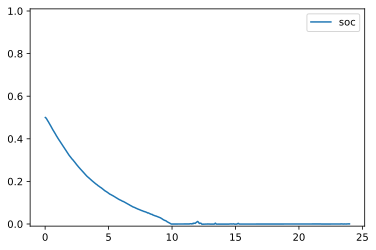

In [11]:
plt.plot(x[:,0], x[:,6], label='soc')
plt.ylim(-0.01,1.01)
plt.legend()
plt.show()

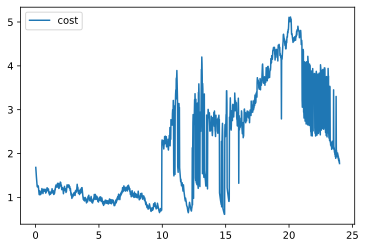

In [12]:
plt.plot(x[:,0], r, label='cost')
plt.legend()
plt.show()

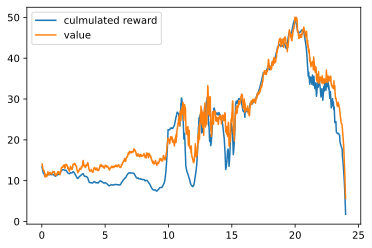

In [13]:
plt.plot(x[:,0], Q_x_a, label='culmulated reward')
plt.plot(x[:,0], values[1:], label='value')
plt.legend()
plt.show()

In [38]:
r.sum()/(60*24)

2.777253359147193

NameError: name 'Q_net' is not defined

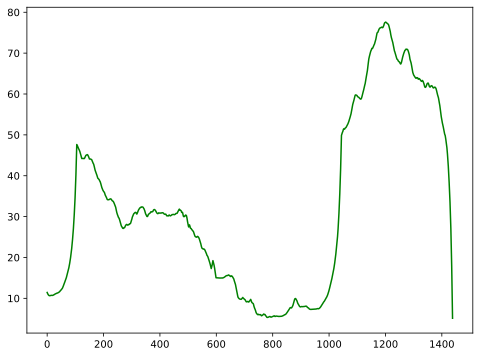

In [25]:
fig, (ax1)=plt.subplots(1,1,figsize=(8,6))
ax1.plot(Q_x_a[:],'g',label='$V(x,t)$ (Simulation)')
ax1.plot(Q_net[:],'r',label='$V(x,t)$ (Learned)')
#ax1.plot(Q[:],'g--',label='Q(x,a)* (Simulation with Random Action)')
ax1.legend()

fig.tight_layout()
fig.show()

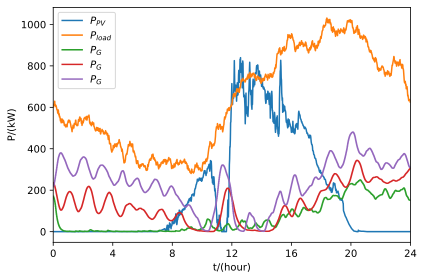

In [8]:
plt.plot(x[:,0],x[:,1],label=r'$P_{PV}$')
plt.plot(x[:,0],x[:,2],label=r'$P_{load}$')
plt.step(x[:,0],x[:,3:6],label=r'$P_G$')
plt.ylabel('P/(kW)')
plt.xlabel('t/(hour)')
plt.xlim([0,24])
plt.xticks(np.arange(0,25,4))
plt.legend()
plt.tight_layout()

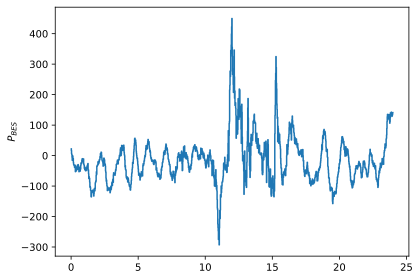

In [9]:
plt.step(x[:,0],x[:,1]-x[:,2]+x[:,3]+x[:,4]+x[:,5])
plt.ylabel(r'$P_{BES}$')
plt.tight_layout()

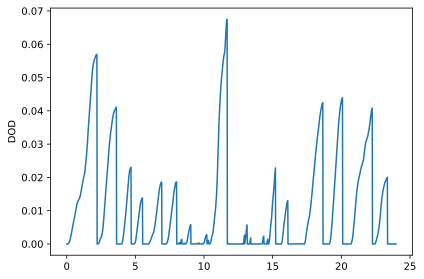

In [10]:
plt.plot(x[:,0],x[:,6])
plt.ylabel('DOD')
plt.tight_layout()

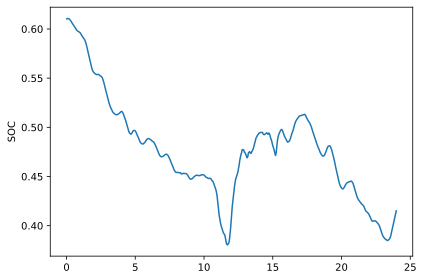

In [11]:
plt.plot(x[:,0],x[:,7])
plt.ylabel('SOC')
plt.tight_layout()

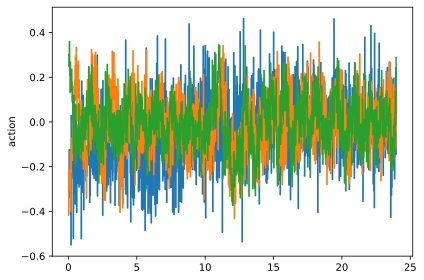

In [12]:
plt.step(x[:,0],a)
plt.ylabel('action')
plt.tight_layout()

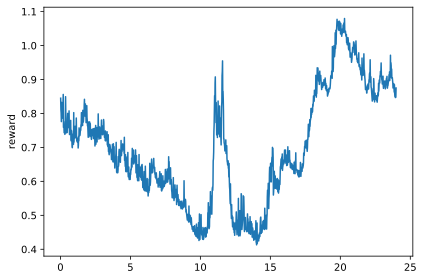

In [13]:
plt.plot(x[:,0],r)
plt.ylabel('reward')
plt.tight_layout()

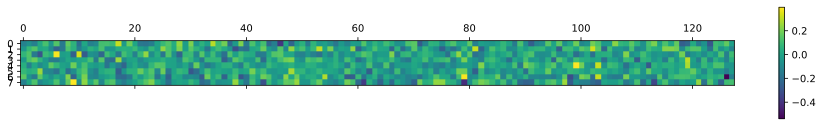

In [14]:
plt.matshow(net.input_feature[0].weight.data.cpu().T)
plt.colorbar()

In [70]:
gamma=0.96
env.seed(9331)
mus=[]
thetas=[]
with torch.no_grad():
    observation = env.preset(soc=0.61)
    while True:
        observation_in=env.observation_scaler(observation)
        observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
        observation_in= torch.unsqueeze(observation_in,dim=0)
        # network forward pass
        input_feature = net.input_feature(observation_in)
        fc_out=net.fc(input_feature)
        mu_out = net.mu(fc_out)
        sigma_out = net.sigma(fc_out)
        theta_out= net.theta(fc_out)
        v_out = net.v(fc_out)
        mus.append(mu_out.detach().cpu().numpy())
        thetas.append(theta_out.detach().cpu().numpy().reshape((3,-1)))
        policies_mu=mu_out+torch.matmul(observation_in,theta_out.reshape((3,-1)).t())
        action=torch.tanh(policies_mu)
        # gather env data, reset done envs and update their obs
        observation, reward, done, info = env.step(action.detach().cpu().numpy()[0])
        if done:
            break

In [75]:
net.mu

Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=128, out_features=3, bias=True)
  (5): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
  (6): Tanh()
)

In [71]:
mus=np.array(mus)
mus=np.squeeze(mus)
thetas=np.array(thetas)
thetas=np.squeeze(thetas)

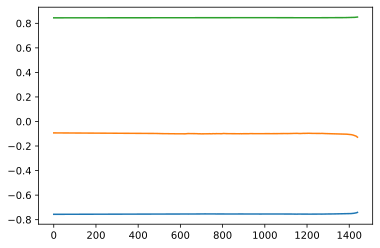

In [72]:
plt.plot(mus)

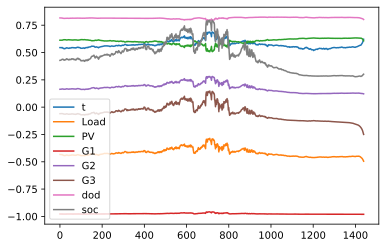

In [105]:
labels=['t','Load','PV','G1','G2','G3','dod','soc']
for i in range(len(labels)):
    plt.plot(thetas[:,0,i],label=labels[i])
plt.legend(loc='best') 

In [79]:
observation = env.preset(0.2)

In [80]:
observation_in=env.observation_scaler(observation)
observation_in = torch.from_numpy(observation_in).to(torch.float32).to(device)
observation_in= torch.unsqueeze(observation_in,dim=0)
observation_in

tensor([[0.0000, 0.0000, 0.5931, 0.4194, 0.5630, 0.2041, 0.0000, 0.2000]],
       device='cuda:0')

In [103]:
observation_in.requires_grad_()
net.zero_grad()
input_feature = net.input_feature(observation_in)
fc_out=net.fc(input_feature)
mu_out = net.mu(fc_out)
sigma_out = net.sigma(fc_out)
theta_out= net.theta(fc_out)
v_out = net.v(fc_out)
torch.autograd.grad(v_out[:], observation_in)

(tensor([[-0.5257,  1.3696,  0.7486, -1.1521,  0.0298,  0.5777, -1.9428,  0.2364]],
        device='cuda:0'),)

In [42]:
mu=[]
inputs= np.linspace(0,1,50)
with torch.no_grad():
    for i in inputs:
        observation_in[0,3]=i
        policies_mu, _,_= net(observation_in)
        mu.append(policies_mu.detach().cpu().numpy())
mu=np.squeeze(np.array(mu))

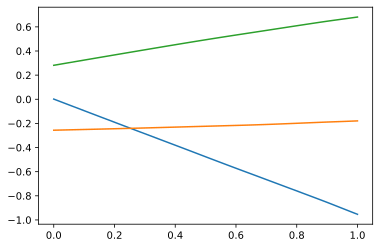

In [43]:
plt.plot(inputs,mu)

In [18]:
input_feature = net.input_feature(observation_in)
fc_out=net.fc(input_feature)
mu_out = net.mu(fc_out)
sigma_out = net.sigma(fc_out)
theta_out = net.theta(fc_out)
v_out = net.v(fc_out)

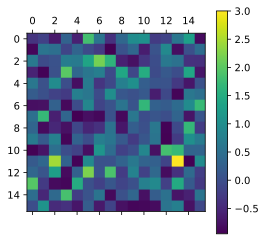

In [19]:
plt.matshow(input_feature.detach().cpu().reshape((16,-1)))
plt.colorbar()

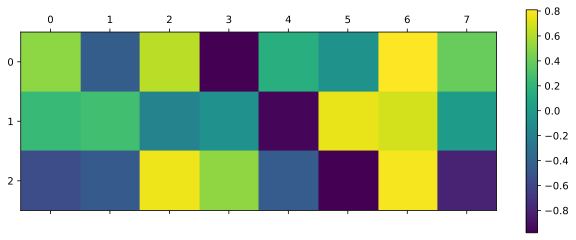

In [20]:
plt.matshow(theta_out.detach().cpu().reshape((3,-1)))
plt.colorbar()

In [21]:
theta_out.detach().cpu().reshape((3,-1))

tensor([[ 0.5085, -0.4524,  0.6256, -0.9797,  0.1507, -0.0641,  0.8097,  0.3971],
        [ 0.2275,  0.2673, -0.1826, -0.0722, -0.9481,  0.7517,  0.6871,  0.0053],
        [-0.5598, -0.4708,  0.7627,  0.5111, -0.4578, -0.9741,  0.7856, -0.8048]])

tensor([[-0.7398, -0.1423,  0.8566]])


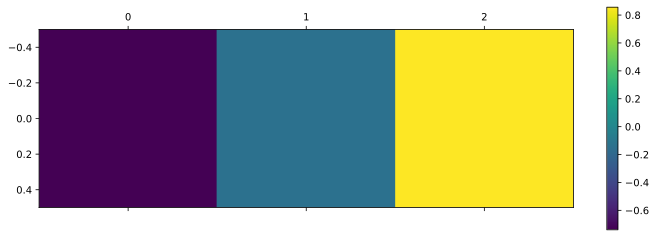

In [114]:
plt.matshow(mu_out.detach().cpu())
plt.colorbar()
print(mu_out.detach().cpu())

In [64]:
policies_mu, _,_=net(observation_in)
action=torch.tanh(policies_mu)
observation, _,_,_ = env.step(action.detach().cpu().numpy()[0])